In [13]:
import tensorflow as tf
import random as python_random
import os
import numpy as np
import matplotlib.pyplot as plt
import math


np.random.seed(42)
tf.random.set_seed(42)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height, width = 224, 224
batch_size=16

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

train_dir = 'data/train'
test_dir = 'data/test'

train_gen = generate_data(train_dir)
test_gen = generate_data(test_dir)
total_image = np.concatenate([train_gen.labels, test_gen.labels])

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
{'Normal': 0, 'Viral Pneumonia': 1, 'Covid': 2}
{'Normal': 0, 'Viral Pneumonia': 1, 'Covid': 2}


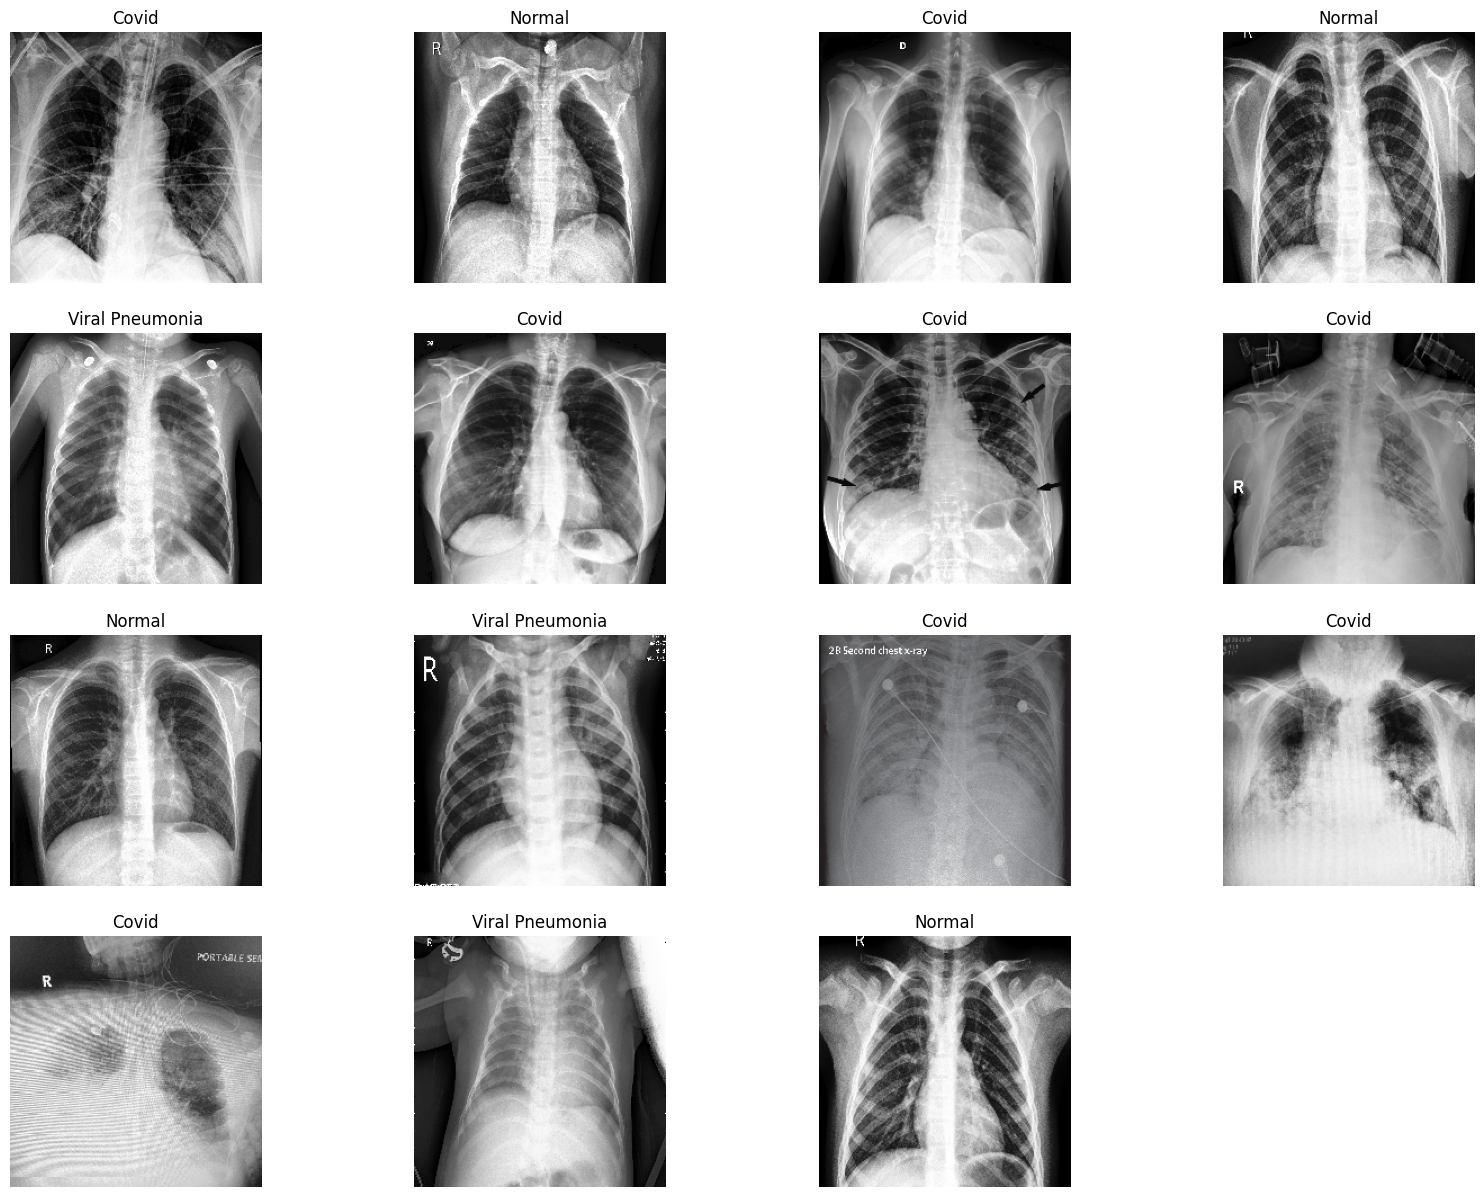

In [15]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_gen,15)

In [16]:
from tensorflow.keras.layers.experimental import preprocessing
tf.keras.backend.clear_session()
input_shape = (height, width, 3)

base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)

base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_gen,
        validation_data = test_gen,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.1835 - acc: 0.3426
Epoch 1: acc improved from -inf to 0.34263, saving model to model/vgg16_best.h5
16/16 [==============================] - 25s 2s/step - loss: 1.1835 - acc: 0.3426 - val_loss: 0.9989 - val_acc: 0.4848
Epoch 2/50


/home/aryan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 0.9918 - acc: 0.5060
Epoch 2: acc improved from 0.34263 to 0.50598, saving model to model/vgg16_best.h5
16/16 [==============================] - 24s 2s/step - loss: 0.9918 - acc: 0.5060 - val_loss: 0.8710 - val_acc: 0.6061
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.8998 - acc: 0.5538
Epoch 3: acc improved from 0.50598 to 0.55378, saving model to model/vgg16_best.h5
16/16 [==============================] - 23s 1s/step - loss: 0.8998 - acc: 0.5538 - val_loss: 0.7301 - val_acc: 0.8788
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.6969 - acc: 0.6892
Epoch 4: acc improved from 0.55378 to 0.68924, saving model to model/vgg16_best.h5
16/16 [==============================] - 24s 1s/step - loss: 0.6969 - acc: 0.6892 - val_loss: 0.5446 - val_acc: 0.8788
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 0.6452 - acc: 0.7052
Epoch 5: acc improved from 0.68924 to 0.70518, sa

In [20]:
train_result = model_vgg16.evaluate(train_gen)
test_result = model_vgg16.evaluate(test_gen)

print("Train Loss:", train_result[0])
print("Train Accuracy:", train_result[1])
print("Test Loss:", test_result[0])
print("Test Accuracy:", test_result[1])

5/5 [==============================] - 5s 832ms/step - loss: 0.1322 - acc: 0.9545
Train Loss: 0.07371771335601807
Train Accuracy: 0.9721115827560425
Test Loss: 0.13221760094165802
Test Accuracy: 0.9545454382896423
